# Loss Function Design

The loss function in train.py has hard edges where it is not differentiable.
Here are some ideas for fixing the loss function in train-v2.py.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

%matplotlib inline

In [2]:
@tf.function
def soft_clip(x, clip_value, alpha=0.1):
    return (2 * tf.math.sigmoid(x * 0.5) - 1) * clip_value + alpha * x

@tf.function
def clipped_loss(y_true, y_pred, clip_value):
    y_true = tf.clip_by_value(y_true, -clip_value, clip_value)
    return tf.abs(y_true - y_pred)

# Huber loss, use soft_clip on y_true, and also on the error.
@tf.function
def soft_loss(y_true, y_pred, delta):
    y_true = soft_clip(y_true, delta)
    error = soft_clip(y_true - y_pred, delta, 0.5) / 2
    squared_loss = 0.5 * tf.square(error)
    linear_loss  = delta * tf.abs(error) - 0.5 * delta**2
    return tf.where(tf.abs(error) < delta, squared_loss, linear_loss)

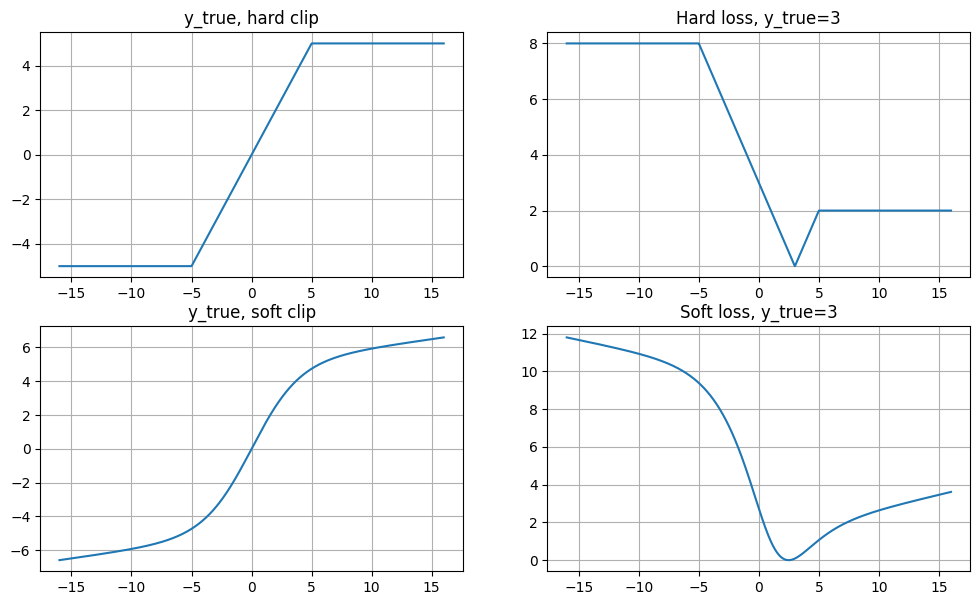

In [3]:
clip_value = 5

y_true = tf.constant(np.linspace(-16, 16, 1000).astype(np.float32))
y_pred = tf.constant(3.0, dtype=tf.float32, shape=y_true.shape)

loss_values = clipped_loss(y_true, y_pred, clip_value)
soft_losses = soft_loss(y_true, y_pred, clip_value)

_, ax = plt.subplots(2, 2, figsize=(12, 7))
[[b.grid(True) for b in a] for a in ax]
ax[0,0].plot(y_true, tf.clip_by_value(y_true, -clip_value, clip_value))
ax[0,0].set_title('y_true, hard clip')
ax[1,0].plot(y_true, soft_clip(y_true, clip_value))
ax[1,0].set_title('y_true, soft clip')
ax[0,1].plot(y_true, loss_values)
ax[0,1].set_title('Hard loss, y_true=3')
ax[1,1].plot(y_true, soft_losses)
ax[1,1].set_title('Soft loss, y_true=3')

plt.show()


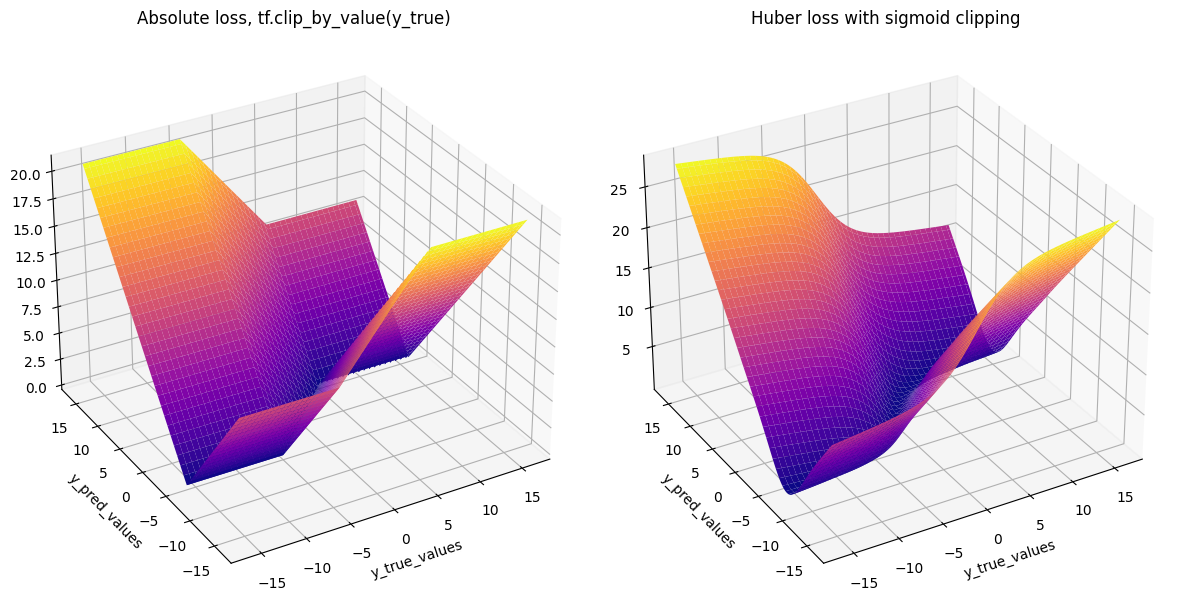

In [4]:
def mesh_grid():
    # Create a range of y_true and y_pred values
    y_true_values = np.linspace(-16, 16, 100)
    y_pred_values = np.linspace(-16, 16, 100)
    return np.meshgrid(y_pred_values, y_true_values)
    
Y_pred, Y_true = mesh_grid()

loss_values = clipped_loss(Y_true, Y_pred, clip_value)
soft_losses = soft_loss(Y_true, Y_pred, clip_value)

# Plot loss values
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(Y_true, Y_pred, loss_values, cmap='plasma')
ax1.set_title('Absolute loss, tf.clip_by_value(y_true)')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(Y_true, Y_pred, soft_losses, cmap='plasma')
ax2.set_title('Huber loss with sigmoid clipping')
for a in [ax1, ax2]:
    a.set_xlabel('y_true_values')
    a.set_ylabel('y_pred_values')
    a.view_init(elev=30, azim=240)

plt.tight_layout()
plt.show()


The loss function on the right has a similar shape to the one on the left but it is smooth (and thus differentiable) everywhere.

### Another idea, that may improve strategic abilities:

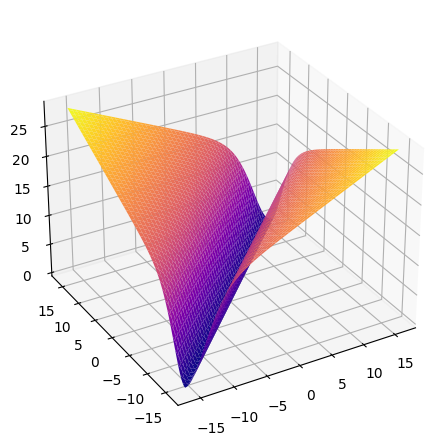

In [5]:
# Huber loss, soft-clip the error, do not clip y_true
def soft_loss_v2(y_true, y_pred, delta):
    error = soft_clip(y_true - y_pred, delta)
    squared_loss = 0.5 * tf.square(error)
    linear_loss  = delta * tf.abs(error) - 0.5 * delta**2
    return tf.where(tf.abs(error) < delta, squared_loss, linear_loss)

Y_pred, Y_true = mesh_grid()

soft_losses = soft_loss_v2(Y_true, Y_pred, clip_value)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(Y_true, Y_pred, soft_losses, cmap='plasma')
ax.view_init(elev=30, azim=240)

plt.show()